# SNAX package tutorial

In [1]:
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm
import numpy as np
from multimessenger.supernova import Supernova_Models as sn
from multimessenger.supernova.Plotter import Plotter
import plotly.express as px
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
import straxen
straxen.print_versions(('strax', 'straxen', 'cutax', 'wfsim'))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
2,straxen,1.8.3,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
3,cutax,1.13.0,/dali/lgrandi/xenonnt/software/cutax/latest/cutax,None
4,wfsim,1.0.1,/home/melih/software/WFSim/wfsim,branch:master | d72c1b3


The `SNAX` is a wrapper around `snewpy` and it allows to compute CEvNS rates for all the snewpy models.

Each model contains variuous simulations with e.g. different EoS, or different progenitor properties. <br>
When only `model_name` is passed to `sn.Models()` it displays the existing files and asks you to select one. Otherwise, `filename` or `index` can be passed. <br>
Once the model is executed, and after every heavy computation the data is saved, and the next time it is directly fetched from the stored data. <br>
The output folder can be specified with the `storage` argument.

In [3]:
m = sn.Models("Nakazato_2013", index=5)

> You chose ~wisely~ ->	   [5]	nakazato-shen-z0.004-t_rev200ms-s50.0.fits
> Retrieving object self.storage/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s50_0_fits.pickle


In [4]:
m

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev200ms-s50.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $50$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.004 |
|Revival time | $200$ $\mathrm{ms}$|
|composite | Xenon|
|duration | 20.05 s|
|distance | 10.0 kpc|
|volume | 5.9 t|
|executed | True|
|SN rate | 81 ct|

In [5]:
m.display_history

,date,version,user,history
0,2022/08/23 - 09:11 UTC,1.2.0,melih,Data Saved!
1,2022/08/23 - 09:12 UTC,1.2.0,melih,Fluxes computed!
2,2022/08/23 - 09:12 UTC,1.2.0,melih,Data Saved!
3,2022/08/23 - 09:13 UTC,1.2.0,melih,simulation Nakazato_single is requested!
4,2022/08/23 - 09:20 UTC,1.2.0,melih,simulation Nakazato5_highstat is requested!


In [6]:
# m.compute_rates()

These parts are better done in dali/midway. <br>


In [7]:
import nestpy
import pandas as pd
import straxen
downloader = straxen.MongoDownloader()
field_file="fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz"
field_map = straxen.InterpolatingMap(
                    straxen.get_resource(downloader.download_single(field_file),
                                         fmt="json.gz"),
                    method="RegularGridInterpolator")

nc = nestpy.NESTcalc(nestpy.DetectorExample_XENON10())
## not sure if nestpy RNG issue was solved, so randomize NEST internal state
for i in range(np.random.randint(100)):
    nc.GetQuanta(nc.GetYields(energy=np.random.uniform(10,100)))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



Caution, the times need to be passed in nanoseconds!

## Simulate ~high statistics t-shifted sample

In [8]:
N_events = 3000
sampled_Er = m.sample_data(N_events)
sampled_t = m.sample_data(N_events, dtype='time')

In [9]:
instr = m.generate_instructions(energy_deposition=sampled_Er, 
                                timemode="shifted", 
                                n_tot=N_events, nc=nc, fmap=field_map)
df = pd.DataFrame(instr)
print(f"Total duration {np.ptp(df['time'])*1e-9:.2f} seconds")
df

Total duration 741.65 seconds


,event_number,type,time,x,y,z,amp,recoil,e_dep,g4id,vol_id,local_field,n_excitons,x_pri,y_pri,z_pri
0,1,1,5613500838,56.297447,11.414064,-9.232842,94,7,2.462575,0,0,30.470859,11,0.0,0.0,0.0
1,1,2,5613500838,56.297447,11.414064,-9.232842,95,7,2.462575,0,0,30.470859,11,0.0,0.0,0.0
2,2,1,160928631,-8.744976,30.809288,-32.052525,55,7,1.697520,0,0,24.372408,2,0.0,0.0,0.0
3,2,2,160928631,-8.744976,30.809288,-32.052525,67,7,1.697520,0,0,24.372408,2,0.0,0.0,0.0
4,3,1,119936267,55.236656,1.650221,-71.289772,262,7,4.787097,0,0,21.748554,14,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5377,2995,1,729219213253,-0.049688,25.602879,-111.787025,12,7,1.071426,0,0,22.196521,0,0.0,0.0,0.0
5378,2995,2,729219213253,-0.049688,25.602879,-111.787025,68,7,1.071426,0,0,22.196521,0,0.0,0.0,0.0
5379,2996,2,731270897317,2.901443,-16.176447,-17.469126,20,7,0.251717,0,0,25.555386,0,0.0,0.0,0.0
5380,2997,1,721889725149,53.545223,28.611919,-35.820099,67,7,1.948588,0,0,22.264173,3,0.0,0.0,0.0


In [11]:
st = m.simulate_one(df, "Nakazato5_highstat2")

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s50_0_fits.pickle!



/home/melih/software/WFSim/wfsim/load_resource.py:262: RuntimeWarning: invalid value encountered in true_divide
  orig_aft_=np.mean((s2map_topeff_/s2map_toteff_)[s2map_toteff_>0.0])
*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/5199 [00:00<?, ?it/s]

RawRecordsFromFaxNT with object id: 140452415900640 waits for chunk 1
RawRecordsFromFaxNT with object id: 140452415900640 waits for chunk 2
RawRecordsFromFaxNT with object id: 140452415900640 waits for chunk 3
RawRecordsFromFaxNT with object id: 140452415900640 waits for chunk 4
RawRecordsFromFaxNT with object id: 140452415900640 waits for chunk 5
RawRecordsFromFaxNT with object id: 140452415900640 waits for chunk 6
RawRecordsFromFaxNT with object id: 140452415900640 waits for chunk 7
Source finished!
Nakazato5_highstat2 is created! Returning context!


In [12]:
m.display_simulation_history

date  \
versions                                           runid                                         
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                  2022/08/23 - 09:13 UTC   
                                                   NaN                  2022/08/23 - 09:20 UTC   
                                                   NaN                  2022/08/23 - 09:59 UTC   
                                                   Nakazato5_highstat2  2022/08/23 - 09:59 UTC   

                                                                         user  \
versions                                           runid                        
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                  melih   
                                                   NaN                  melih   
                                                   NaN                  melih   
                                                   Nakazato5_highstat2  melih   

                                                                                                                    model  \
versions                                           runid                                                                    
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                  Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-...   
                                                   NaN                  Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-...   
                                                   NaN                  Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-...   
                                                   Nakazato5_highstat2  Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-...   

                                                                       single SN events  \
versions                                           runid                                  
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                               81   
                                                   NaN                               81   
                                                   NaN                               81   
                                                   Nakazato5_highstat2               81   

                                                                        size  \
versions                                           runid                       
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                   146   
                                                   NaN                  5379   
                                                   NaN                  5382   
                                                   Nakazato5_highstat2  5382   

                                                                       context hash  
versions                                           runid                             
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                          NaN  
                                                   NaN                          NaN  
                                                   NaN                   rvchefp73l  
                                                   Nakazato5_highstat2   rvchefp73l

In [13]:
truth = st.get_df("Nakazato5_highstat2", "truth")

Loading truth: |          | 0.00 % [00:00<?]

In [20]:
peak_basics = st.get_df("Nakazato5_highstat2", "peak_basics")

Loading peak_basics: |          | 0.00 % [00:00<?]

In [21]:
peak_s1 = peak_basics[peak_basics['type'] == 1]
peak_s2 = peak_basics[peak_basics['type'] == 2]
peak_basics['type'].unique(), sum(peak_basics['type']==0), sum(peak_basics['type']==1), sum(peak_basics['type']==2)

(array([2, 1, 0], dtype=int8), 79, 1388, 2720)

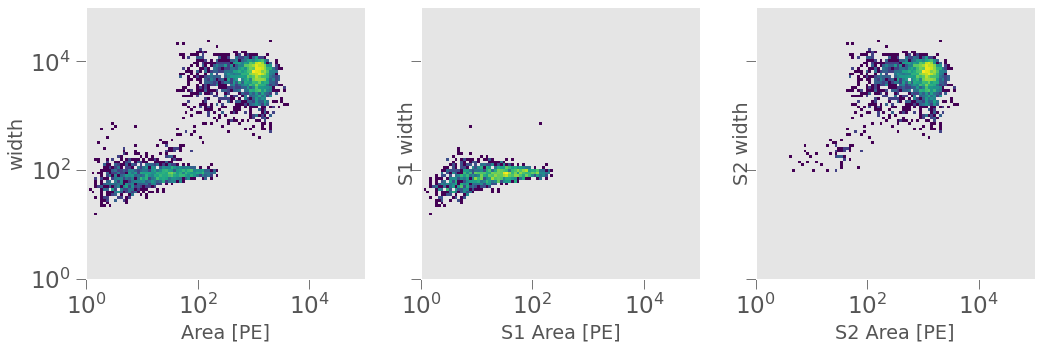

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

### Test different simulation configurations

In [24]:
import cutax, strax
st2 = cutax.contexts.xenonnt_sim_SR0v2_cmt_v8(cmt_run_id="026000", 
                                             output_folder=os.path.join(m.config['wfsim']['sim_folder'], "strax_data"))
# set s1 minimum coincidence to 0
st2.set_config({"s1_min_coincidence":0})

In [ ]:
st2 = m.simulate_one(df, "Nakazato5_highstat2_st2", context=st2)

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s50_0_fits.pickle!



*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/5199 [00:00<?, ?it/s]

RawRecordsFromFaxNT with object id: 140451998268912 waits for chunk 1
RawRecordsFromFaxNT with object id: 140451998268912 waits for chunk 2
RawRecordsFromFaxNT with object id: 140451998268912 waits for chunk 3
RawRecordsFromFaxNT with object id: 140451998268912 waits for chunk 4


In [ ]:
peak_basics2 = st2.get_df("Nakazato5_highstat2", "peak_basics")

In [ ]:
peak_s12 = peak_basics2[peak_basics2['type'] == 1]
peak_s22 = peak_basics2[peak_basics2['type'] == 2]
peak_basics2['type'].unique(), sum(peak_basics2['type']==0), sum(peak_basics2['type']==1), sum(peak_basics2['type']==2)

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics2["area"], peak_basics2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s12["area"], peak_s12["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s22["area"], peak_s22["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

**Fornax_2021 Model**

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $25$ $\mathrm{M_{\odot}}$|
|composite | Xenon|
|distance | 10.0 kpc|
|duration | 3.44 s|
|executed | True|

### Test the plugin

In [ ]:
from sn_rate_plugin import SNPugin
st.register(SNPugin)

In [29]:
df_test = st.get_df([runid], 'sn_rate')

Loading sn_rate: |          | 0.00 % [00:00<?]

In [30]:
df_test

,sn_rate,sn_rate_err,time,endtime
0,256.568619,8.216772,25932090,3826085060


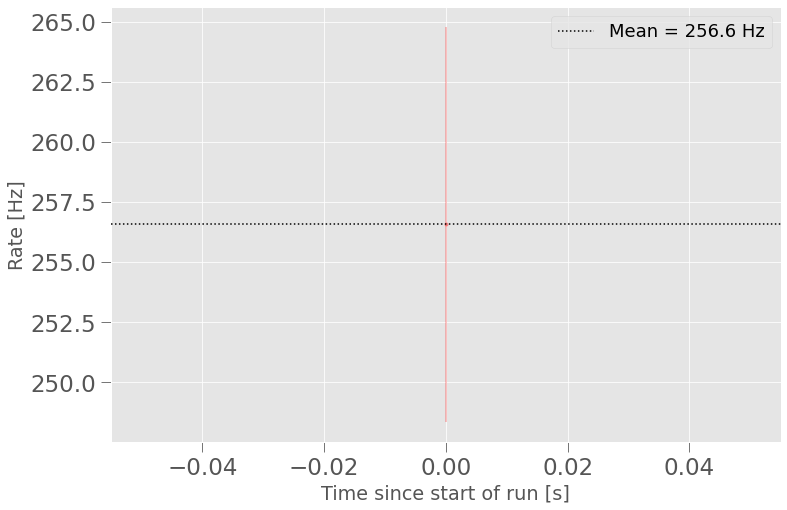

In [26]:
plt.figure(figsize=(12,8))
plt.errorbar(x=(df_test['time']-df_test['time'][0])/1e9, 
             y=df_test['sn_rate'],
             yerr=df_test['sn_rate_err'], 
             color='r', marker='.',linestyle='',alpha=0.3)
plt.axhline(np.mean(df_test['sn_rate']), color='k',linestyle=':', 
            zorder=10, label='Mean = %.1f Hz'%np.mean(df_test['sn_rate']))

plt.legend()
plt.xlabel('Time since start of run [s]')
plt.ylabel('Rate [Hz]')
plt.show()

In [ ]:
# theta = 23.55*u.degree
# phi = 22.5*u.degree
# m.compute_rates(phi=phi, theta=theta)